In [1]:
import random
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch as T
import numpy as np
from torch.optim.lr_scheduler import StepLR

USE_CUDA = T.cuda.is_available()

LongTensor = T.cuda.LongTensor if USE_CUDA else T.LongTensor
FloatTensor = T.cuda.FloatTensor if USE_CUDA else T.FloatTensor

## 1.1 Precision, recall and F1 score

In [27]:
generate_confusion_matrix(flatten(predicts), flatten(val_ys), index2tag)

Label      Precision  Recall     F1         Support   
ORG        0.71       0.84       0.77       1479.00   
O          0.99       0.97       0.98       42674.00  
MISC       0.75       0.87       0.80       949.00    
PER        0.78       0.95       0.85       2442.00   
LOC        0.87       0.90       0.88       1816.00   

Avg        0.82       0.90       0.86       9872.00   


## 1.2 Example from validation set

In [32]:
randomDemo(model, val_Xs, val_ys)

Sentence: yeltsin has said any deal should <unknown> russia 's <unknown> <unknown> .
Ground true: PER O O O O O O LOC O O O O
Prediction: PER O O O O O O LOC O O O O
Score: 153.1388


## 1.3 Hot map 

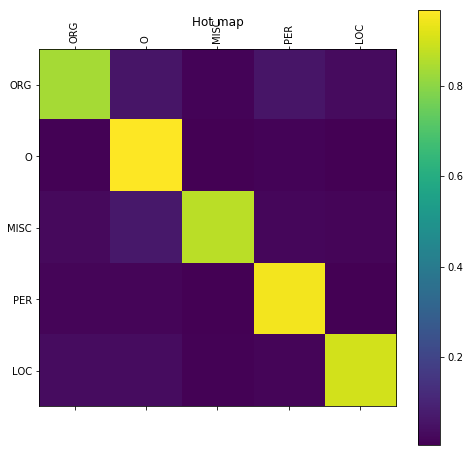

In [30]:
show_hot_map(flatten(predicts), flatten(val_ys), index2tag)

In [2]:
def readConll(filename):
    """
    return:
        sentences: list. [[],[],...]
        tags: list: [[],[]]
    """
    sentences = []
    tags = []
    with open(filename) as f:
        #drop first two lines
        line = f.readline()
        line = f.readline()
        line = f.readline()
        sentence = []
        tag = []
        while line:
            line = line.strip()
            if len(line)==0:
                sentences.append(sentence)
                tags.append(tag)
                sentence = []
                tag = []
            else:
                s, t = line.split('\t')
                s = s.lower()
                sentence.append(s)
                tag.append(t)
            line = f.readline()
    return sentences, tags

def _to_ix(arr, count=False):
    """
    arr:[[],[]..]
    """
    to_ix = {}
    counter = {}
    for ar in arr:
        for c in ar:
            if not to_ix.has_key(c):
                to_ix[c] = len(to_ix)
                counter[c] = 1
            else:
                counter[c] += 1
    if count:
        return to_ix, counter
    else:
        return to_ix

In [3]:
train_sentences, train_tags = readConll('train.conll')
val_sentences, val_tags = readConll('dev.conll')

In [4]:
START_TAG = 'START'
END_TAG = 'END'

MIN_OCC = 2 #出现次数低于这个数字，则删除该单词
word2index = {'<pad>':0, '<unknown>':1}

_, wordcounter = _to_ix(train_sentences, count=True)
print "Num of words before trim: %d"%(len(wordcounter))
for k, v in wordcounter.items():
    if v>=MIN_OCC:
        word2index[k] = len(word2index)
        
print "Num of words after trim: %d"%(len(word2index))

tag2index = _to_ix(train_tags)
tag2index[START_TAG] = len(tag2index)
tag2index[END_TAG] = len(tag2index)

index2tag = {v:k for k,v in tag2index.items()}
index2word = {v:k for k,v in word2index.items()}

Num of words before trim: 21010
Num of words after trim: 10952


In [5]:
a = [[1,2], [3]]
b = np.copy(a)
b[0].append(1)
a

[[1, 2, 1], [3]]

In [25]:
#convert sentence to list
from copy import deepcopy

def prepare_sequence(seqs, to_ix):
    res = []
    for seq in seqs:
        r = []
        for w in seq:
            if to_ix.has_key(w):
                r.append(to_ix[w])
            else:
                r.append(to_ix['<unknown>'])
        res.append(r)
    return np.array(res)

def ix_to_c(seq, ix_to):
    res = []
    for c in seq:
        res.append(ix_to[c])
    return " ".join(res)

def get_batch(sentences, tags, batch_size):
    #sentences = np.copy(sentences)
    #tags = np.copy(tags)
    indexes = np.arange(len(sentences))
    random.shuffle(indexes)
    sindex = 0
    eindex = batch_size
    while eindex<len(sentences):
        batch_idx = indexes[sindex:eindex]
        batch_X = sentences[batch_idx]
        tmp = zip(batch_idx, batch_X)
        tmp = sorted(tmp, key=lambda x:len(x[1]), reverse=True)
        sort_indexes = [x[0] for x in tmp]
        batch_X = deepcopy(sentences[sort_indexes])
        batch_y = deepcopy(tags[sort_indexes])
        max_len = len(batch_X[0])
        seq_len = []
        for i in xrange(len(batch_X)):
            seq_len.append(len(batch_X[i]))
            while len(batch_X[i])<max_len:
                batch_X[i].append(word2index['<pad>'])
                batch_y[i].append(batch_y[i][-1])
        yield batch_X, batch_y, seq_len
        sindex = eindex
        eindex += batch_size
    if sindex<len(sentences):
        batch_X = sentences[batch_idx]
        tmp = zip(batch_idx, batch_X)
        tmp = sorted(tmp, key=lambda x:len(x[1]), reverse=True)
        sort_indexes = [x[0] for x in tmp]
        batch_X = deepcopy(sentences[sort_indexes])
        batch_y = deepcopy(tags[sort_indexes])
        max_len = len(batch_X[0])
        seq_len = []
        for i in xrange(len(batch_X)):
            seq_len.append(len(batch_X[i]))
            while len(batch_X[i])<max_len:
                batch_X[i].append(word2index['<pad>'])
                batch_y[i].append(batch_y[i][-1])
        yield batch_X, batch_y, seq_len
        sindex = eindex     
        
        
def get_order_sample(sentences):
    indexes = list(xrange(len(sentences)))
    for index in indexes:
        sentence = sentences[index]
        seq_len = [len(sentence)]
        yield Variable(LongTensor(sentence).view(1, -1)), seq_len

In [7]:
train_Xs = prepare_sequence(train_sentences, word2index)
train_ys = prepare_sequence(train_tags, tag2index)

val_Xs = prepare_sequence(val_sentences, word2index)
val_ys = prepare_sequence(val_tags, tag2index)

In [8]:
def log_sum_exp(vec):
    """
    vec: BxT->Bx1
    """
    if len(vec.size())>1:
        max_value = vec.max(1)[0].view(-1, 1) #B,
        res = max_value + T.log(T.sum(T.exp(vec-max_value), dim=1, keepdim=True))
    else:
        max_value = vec.data.max()
        res = max_value + T.log(T.sum(T.exp(vec-max_value)))
    return res
    

class BiLSTM_RCF(nn.Module):
    def __init__(self, vocab_size, tag2index, embedding_size, hidden_size):
        super(BiLSTM_RCF, self).__init__()
        
        self.hidden_size = hidden_size
        self.tag_size = len(tag2index)
        self.tag2index = tag2index
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        #transitions, x方向是如果转到该index，transition的值
        self.transitions = nn.Parameter(T.randn(self.tag_size, self.tag_size))
         
        self.lstm = nn.LSTM(embedding_size, hidden_size//2, batch_first=True, 
                            bidirectional=True)
        self.fc = nn.Linear(hidden_size, self.tag_size)
        
        #不允许转到start tag
        self.transitions.data[tag2index[START_TAG], :].fill_(-10000)
        #不允许从end tag转出来
        self.transitions.data[:, tag2index[END_TAG]].fill_(-10000)
        
    def _init_hiddens(self, batch_size):
        h = Variable(T.zeros(2, batch_size, self.hidden_size//2).type(FloatTensor))
        c = Variable(T.zeros(2, batch_size, self.hidden_size//2).type(FloatTensor))
        return (h, c)
    
    def _forward_alg(self, feats, seq_len):
        """
        feats: BxLxT
        """
        B = feats.size(0)
        L = feats.size(1)
        forward_var = T.ones(B, self.tag_size).type(FloatTensor)*(-10000)
        forward_var[:, self.tag2index[START_TAG]] = 0
        
        forward_var = Variable(forward_var)
        
        seq_len_ = Variable(T.LongTensor(seq_len))
        bindex = LongTensor(list(xrange(feats.size(0))))
        for f_idx in xrange(L):
            next_scores = []
            mask = seq_len_.gt(f_idx).type(FloatTensor).view(B, 1)
            #unmask = seq_len_.lt(f_idx).type(FloatTensor).view(B, 1)
            for tag_idx in xrange(self.tag_size):
                tags = LongTensor([tag_idx]*B)
                emis_score = feats[bindex, LongTensor([f_idx]), tags].view(B, 1) #B, 
                tran_score = self.transitions[tags] #BxT
                score = emis_score + tran_score + forward_var
                score = log_sum_exp(score)*mask + forward_var[:, tag_idx].contiguous().view(-1, 1)*(1-mask) #B,1
                next_scores.append(score)
            forward_var = T.cat(next_scores, dim=1) #BxT
        end_tags = LongTensor([self.tag2index[END_TAG]]*B)
        final_score = forward_var + self.transitions[end_tags] #BxT
        
        return log_sum_exp(final_score) #B,1
    
    def _score_sentence(self, feats, tags, seq_len):
        seq_len_ = Variable(LongTensor(seq_len))
        score = Variable(T.zeros(feats.size(0),).type(FloatTensor))
        previous_tag = LongTensor([self.tag2index[START_TAG]]*feats.size(0))
        bindex = LongTensor(list(xrange(feats.size(0))))
        for i in xrange(feats.size(1)):
            mask = seq_len_.gt(i).type(FloatTensor)
            tag = tags[:, i].data #B,
            tran_score = self.transitions[tag, previous_tag] #B,
            emis_score = feats[bindex, LongTensor([i]), tag] #B,
            previous_tag = tag
            score += (emis_score + tran_score)*mask
        ends_tags = LongTensor([self.tag2index[END_TAG]]*feats.size(0))
        score += self.transitions[ends_tags, previous_tag]
        return score
    
    def _get_lstm_features(self, sentence, seq_len):
        x = self.embedding(sentence) #B x L x D
        hiddens = self._init_hiddens(x.size(0))
        
        pack = nn.utils.rnn.pack_padded_sequence(x, seq_len, batch_first=True)
        
        output, hiddens = self.lstm(pack, hiddens) #B x L x H
        
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        #output: B x L x H
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        return output # (B*L)xT
    
    def calculate_loss(self, sentence, tags, seq_len):
        """
        tag padding重复最后一位，因为计算需要用到
        """
        feats = self._get_lstm_features(sentence, seq_len)
        feats = feats.view(sentence.size(0), sentence.size(1), self.tag_size) #BxLxT
        numerator = self._score_sentence(feats, tags, seq_len) 
        denominator = self._forward_alg(feats, seq_len)
        "negative log likelihood"
        
        return T.mean(denominator - numerator)
    
    def viterbi_decode(self, sentence, seq_len):
        feats = self._get_lstm_features(sentence, seq_len)
        
        feats = feats.cpu().data.numpy()
        forward_var = np.ones(self.tag_size)*(-10000.0)
        forward_var[self.tag2index[START_TAG]] = 0.0
        
        previous_tag = 0
        paths = []
        for feat in feats:
            path = []
            scores = np.zeros(self.tag_size)
            for i in xrange(self.tag_size):
                tran_score = self.transitions[i]
                score = tran_score.cpu().data.numpy() + forward_var
                index = np.argmax(score)
                scores[i] = max(score)
                path.append(index)
            forward_var = scores + feat
            paths.append(path)
        
        final_score = forward_var + self.transitions[self.tag2index[END_TAG]].cpu().data.numpy()
        
        index = np.argmax(final_score)
        
        decode_paths = [index]
        for i in xrange(len(paths)-1, 0, -1):
            index = paths[i][index]
            decode_paths.append(index)
            
        return max(final_score), list(reversed(decode_paths))

In [9]:
embedding_size = 50
hidden_size = 128

model = BiLSTM_RCF(len(word2index), tag2index, embedding_size, hidden_size)

if USE_CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [12]:
trainIter(model, train_Xs, train_ys, optimizer, scheduler)

----------
[1/20] loss:9.3583 time_elapse:0m38s
[1/20] loss:4.2603 time_elapse:1m15s
[1/20] loss:2.9628 time_elapse:1m53s
[1/20] loss:2.2301 time_elapse:2m30s
[1/20] loss:4.2820 time:2m56s
----------
[2/20] loss:1.2512 time_elapse:3m34s
[2/20] loss:1.2174 time_elapse:4m14s
[2/20] loss:1.1042 time_elapse:4m52s
[2/20] loss:1.0427 time_elapse:5m29s
[2/20] loss:1.1251 time:5m55s
----------
[3/20] loss:0.5967 time_elapse:6m33s
[3/20] loss:0.5696 time_elapse:7m11s
[3/20] loss:0.6920 time_elapse:7m49s
[3/20] loss:0.6619 time_elapse:8m26s
[3/20] loss:0.6323 time:8m52s
----------
[4/20] loss:0.4003 time_elapse:9m30s
[4/20] loss:0.3898 time_elapse:10m8s
[4/20] loss:0.4154 time_elapse:10m45s
[4/20] loss:0.4165 time_elapse:11m22s
[4/20] loss:0.4100 time:11m48s
----------
[5/20] loss:0.2686 time_elapse:12m27s
[5/20] loss:0.2513 time_elapse:13m5s
[5/20] loss:0.2257 time_elapse:13m41s
[5/20] loss:0.3144 time_elapse:14m18s
[5/20] loss:0.2767 time:14m44s
----------
[6/20] loss:0.1924 time_elapse:15m22s

In [13]:
#save model
T.save(model.state_dict(), 'params.pkl')
#model.load_state_dict(T.load('params.pkl'))

In [18]:
import time

def time_elapse(since):
    now = time.time()
    ts = now - since
    return "{:.0f}m{:.0f}s".format(ts//60, ts%60)

def trainIter(model, train_Xs, train_ys, optimizer, scheduler=None, num_epochs=20, batch_size=32, 
              print_every=100):
    since = time.time()
    for epoch in xrange(num_epochs):
        print '-'*10
        if scheduler!=None:
            scheduler.step()
        epoch_loss = 0.0
        print_loss = 0.0
        print_idx = 0
        for X, y, seq_len in get_batch(train_Xs, train_ys, batch_size):
            X = Variable(LongTensor(X))
            y = Variable(LongTensor(y))
            loss = model.calculate_loss(X, y, seq_len)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.data[0]
            print_loss += loss.data[0]
            
            print_idx += 1
            
            if print_idx%print_every==0:
                print "[{}/{}] loss:{:.4f} time_elapse:{}".format(epoch+1, num_epochs, 
                                                                        print_loss/print_idx, 
                                                                        time_elapse(since))
                print_idx = 0
                print_loss = 0.0
            
        print "[{}/{}] loss:{:.4f} time:{}".format(epoch+1, num_epochs, epoch_loss/len(train_Xs)*batch_size,
                                                   time_elapse(since))
        
def randomDemo(model, val_Xs, val_ys):
    index = random.randint(0, len(val_Xs))
    sentence = val_Xs[index]
    tag = val_ys[index]
    seq_len = [len(sentence)]
    
    sentence = Variable(LongTensor(sentence).view(1, -1), volatile=True)
    
    score, path = model.viterbi_decode(sentence, seq_len)
    
    print "Sentence:",ix_to_c(sentence.cpu().data[0], index2word)
    print "Ground true:", ix_to_c(tag, index2tag)
    print "Prediction:", ix_to_c(path, index2tag)
    print "Score: %.4f"%(score)
    
def evaluate(model, val_Xs):
    tags = []
    for X, seq_len in get_order_sample(val_Xs):
        score, path = model.viterbi_decode(X, seq_len)
        tags.append(path)
    return tags

def generate_confusion_matrix(predicts, grounds, ix_to):
    """
    predicts: list
    grounds: list
    labels: dict, index对应的tag
    """
    #0,tp; 1, fn; 2, fp
    confusion_matrix = np.zeros((len(ix_to)-2, 4))
    for i,j in zip(grounds, predicts):
        if i==j:
            confusion_matrix[i,0] += 1
        else:
            confusion_matrix[i,1] += 1
            confusion_matrix[j,2] += 1
    ress = []
    ress.append(['Label', 'Precision','Recall', 'F1', 'Support'])
    ps = 0.0
    rs = 0.0
    f1s = 0.0
    supports = 0
    for i in xrange(confusion_matrix.shape[0]):
        p = confusion_matrix[i][0]/(confusion_matrix[i][1]+confusion_matrix[i][0])
        r = confusion_matrix[i][0]/(confusion_matrix[i][2]+confusion_matrix[i][0])
        f1 = 2*p*r/(p+r)
        ps += p
        rs += r
        f1s += f1
        supports += confusion_matrix[i][0]
        res = [ix_to[i], p, r, f1, confusion_matrix[i][0]]
        ress.append(res)
    ress.append(['Avg', ps/confusion_matrix.shape[0], rs/confusion_matrix.shape[0], 
                 f1s/confusion_matrix.shape[0], supports/confusion_matrix.shape[0]])
    
    for i in xrange(len(ress)):
        for index, ele in enumerate(ress[i]):
            if type(ele)==str:
                print ele.ljust(10),
            else:
                s = '%.2f'%(ele)
                print s.ljust(10),
        print
        if i == len(ress)-2:
            print 
flatten = lambda x: [i for p in x for i in p]

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def show_hot_map(predicts, grounds, to_ix):
    confusion_matrix = np.zeros((len(to_ix)-2, len(to_ix)-2))
    for i, j in zip(predicts, grounds):
        confusion_matrix[i, j] += 1
    confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1, keepdims=True)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    
    labels = []
    for i in xrange(len(to_ix)-2):
        labels.append(to_ix[i])
    
    cax = ax.matshow(confusion_matrix)
    fig.colorbar(cax)
    
    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticklabels([''] + labels)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title('Hot map')
    
    plt.show()

In [26]:
predicts = evaluate(model, val_Xs)